In [166]:
from pathlib import Path
import json
import numpy as np

import geopandas as gpd

from tree_registration_and_matching.eval import obj_mee_matching

from tree_registration_and_matching.register_MEE import align_plot

from tree_registration_and_matching.constants import DATA_DIR
import matplotlib.pyplot as plt

## Simulate example maps
This can be used to simulate data for examples or experiments. Three types of data are generated. The first is a large extent of trees, analogous to predictions made from remote sensing data. The second is a set of trees for a subset of this region, representing field surveyed trees. These two sets of trees are based on the same structured random tree locations, but contain simulated errors that represent what might be realistic differences between field and predicted trees. These include omission or comission errors, random noise, and a consistent shift. The final element is the bounds within which any field trees that are present should be recorded. 

In [167]:
DATASET = "0061_000333_000335"

DETECTED_TREES = Path(DATA_DIR, "ofo-example-2", "detected-trees", f"{DATASET}.gpkg")
FIELD_TREES = Path(DATA_DIR, "ofo-example-2", "field_trees", f"dataset_{DATASET}.gpkg")
PLOTS_FILE = Path(DATA_DIR, "ofo-example-2", "ofo_ground-reference_plots.gpkg")
SHIFTS_FILE = Path(DATA_DIR, "ofo-example-2", "shifts_per_dataset.json")

TEST_SHIFT = (5, 5)

In [168]:
# Read the data
pred = gpd.read_file(DETECTED_TREES)
field_trees = gpd.read_file(FIELD_TREES)
plots = gpd.read_file(PLOTS_FILE)
# And convert the CRS
field_trees.to_crs(pred.crs, inplace=True)
plots.to_crs(pred.crs, inplace=True)
# Read the shifts
with open(SHIFTS_FILE) as infile:
    data = json.load(infile)
shift = data[DATASET][0]

# Extract the one plot from the total
plot_id = DATASET[:4]
plots = plots.query("plot_id==@plot_id")
# The plots were relative to the original trees so they need to be shifted
plots.geometry = plots.translate(xoff=shift[0], yoff=shift[1])

In [169]:
field_trees.geometry = field_trees.translate(xoff=TEST_SHIFT[0], yoff=TEST_SHIFT[1])
plots.geometry = plots.translate(xoff=TEST_SHIFT[0], yoff=TEST_SHIFT[1])

# Plot the data

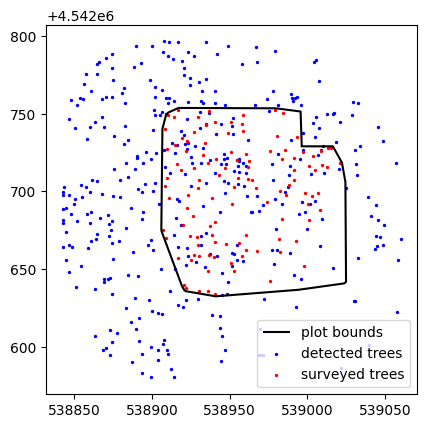

In [170]:
f, ax = plt.subplots()
plots.boundary.plot(ax=ax, color="k", markersize=2, label="plot bounds")
pred.plot(ax=ax, c="b", markersize=2, label="detected trees")
field_trees.plot(ax=ax, c="r", markersize=2, label="surveyed trees")
plt.legend()
plt.show()

Show the simulated maps

## Registration
Run registration between the two datasets. This particular algorithm tries a variety of candidate shifts between the two datasets and computes a quality metric for the alignment at each one. Specifically, it computes the number of trees that satisfy specific matching condidtions. The visualization shows the quality of alignment for each of the attempted shifts.

In [174]:
shifted_field_trees, estimated_shift = align_plot(
    field_trees=field_trees, drone_trees=pred, obs_bounds=plots
)
print(f"Optimal shift applied: {estimated_shift}")
print(f"diff{np.array(TEST_SHIFT) + np.array(estimated_shift)}")

Rough shift: (np.int64(-5), np.int64(-4)), fine shift: (np.float64(-4.799999999999998), np.float64(-4.399999999999999))
Optimal shift applied: (np.float64(-4.799999999999998), np.float64(-4.399999999999999))
diff[0.2 0.6]


## Plot the shifted trees
This plot is similar to the first tree-level plot except that it shows the field trees after the estimated shift has been applied.

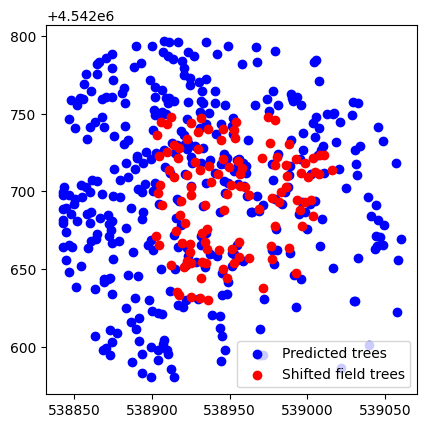

In [172]:
f, ax = plt.subplots(1, 1)
pred.plot(ax=ax, color="blue", label="Predicted trees")
shifted_field_trees.plot(ax=ax, color="red", label="Shifted field trees")
ax.legend()
plt.show()

## Scoring
This computes the F1 score using the definition used in this paper: https://besjournals.onlinelibrary.wiley.com/doi/pdf/10.1111/2041-210X.13860. 

In [173]:
F1_score = obj_mee_matching(
    shifted_field_trees=shifted_field_trees, drone_trees=pred, obs_bounds=plots
)
print(f"F1 score {F1_score}")

F1 score 0.726661305650998
